<a href="https://colab.research.google.com/github/compartia/nlp_tools/blob/tensorflow-model/augmentation_NER_Matcher_(TF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
GLOBALS__={}

## MAIN, init, load code

In [2]:
#@title  { form-width: "300px", display-mode: "form" }
import os






# ''' AZ:-IMPORT CODE GITHUB----------------------------------------------😺------ '''
import sys
# ====================================
# ====================================
_git_branch = "tensorflow-model"  # @param {type:"string"}
# ====================================
# ====================================


def _init_import_code_from_gh():
  if 'GLOBALS__' not in globals():
    print('adding global GLOBALS__')
    global GLOBALS__
    GLOBALS__ = {}

  if '_init_import_code_from_gh' in GLOBALS__:
    print('👌 code already imported from GitHub!')
    return

  import subprocess
  def exec(x):
    r = subprocess.check_output(x, shell=True)
    r = r.decode('unicode-escape').encode('latin1').decode('utf8')
    print(r)

  print(f"fetching code from GitHub.....{_git_branch}")
  try:
    exec('rm -r nlp_tools')
  except:
    pass
  exec(f'git clone --single-branch --branch {_git_branch} https://github.com/compartia/nlp_tools.git nlp_tools')

  print('🦊 GIT revision:')
  exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

  sys.path.insert(0, 'nlp_tools')

  # self-test
  from text_tools import untokenize
  print(untokenize(['code', 'imported', 'OK 👍']))

  print('installing antiword...')
  exec('sudo apt-get install antiword')

  print('installing docx2txt...')
  exec("pip install docx2txt")

  GLOBALS__['_init_import_code_from_gh'] = True

  ''' AZ:-------------------------------------------------IMPORT CODE GITHUB-😺---'''
  print('❤️ DONE importing Code fro GitHub')


# AZ:-INIT ELMO-----------------------------------------------------------------------------------

import tensorflow_hub as hub

#
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML


 

# AZ:- THE CODE----------------------------------------------------------------------------------

def _init_the_code(reset=False):
  if '_init_the_code' in GLOBALS__ and not reset:
    print('👌 Code is alredy imported!')
    return

  from renderer import HtmlRenderer
  from renderer import to_multicolor_text
  from renderer import known_subjects_dict

  from structures import ContractSubject
  from contract_parser import ContractDocument3

  from ml_tools import ProbableValue

  from legal_docs import LegalDocument
  from renderer import as_warning, as_headline_3, as_offset, as_smaller

  class DemoRenderer(HtmlRenderer):

    def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      html = self.to_color_text(tokens, weights, colormap, print_debug, _range)
      display(HTML(html))

    def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      return super()._to_color_text(tokens, weights, mpl, colormap=colormap, _range=_range)

    def render_multicolor_text(self, tokens, vectors, colormap, min_color=None, _slice=None):
      display(HTML(to_multicolor_text(tokens, vectors, colormap, min_color=min_color, _slice=_slice)))

     
     

     
  GLOBALS__['renderer'] = DemoRenderer()

  GLOBALS__['_init_the_code'] = True
  print("❤️ DONE initializing the code")

  # AZ:-------------------------------------------------Init Protocols context===


def read_doc(fn):
  import docx2txt, sys, os

  text = ''
  try:
    text = docx2txt.process(fn)

  except:
    print("Unexpected error:", sys.exc_info())
    os.system('antiword -w 0 "' + fn + '" > "' + fn + '.txt"')
    with open(fn + '.txt') as f:
      text = f.read()

  return text

def interactive_upload(filetype):
  from google.colab import files
  import docx2txt

  print(f'Please select "{filetype}" .docx file:')
  uploaded = files.upload()
  docs = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

    with open(fn, "wb") as df:
      df.write(uploaded[fn])
      df.close()

    # extract text

    text = ''
    try:
      text = docx2txt.process(fn)
    except:
      print("Unexpected error:", sys.exc_info())
      os.system('antiword -w 0 "' + fn + '" > "' + fn + '.txt"')
      with open(fn + '.txt') as f:
        text = f.read()
    print("Символов в оригинальном документе:", len(text))
    docs.append(text)
    return docs

  
# AZ:- ENDO OF THE THE CODE------------------------------------------------XXXX


# 1.
_init_import_code_from_gh()
 
# 3.
_init_the_code(True)



W0515 03:41:23.240281 140259739957120 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


fetching code from GitHub.....tensorflow-model


🦊 GIT revision:
426
* tensorflow-model
Created using Colaboratory
Tiny fixes

Created using Colaboratory

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
code imported OK 👍
installing antiword...
Reading package lists...
Building dependency tree...
Reading state information...
antiword is already the newest version (0.37-11build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.

installing docx2txt...

❤️ DONE importing Code fro GitHub
❤️ DONE initializing the code


### load files from gdrive

In [3]:

from google.colab import auth
from google.colab import drive
 

drive.mount('/content/gdrive', force_remount=True)


import glob
def read_documents(filename_prefix):
  texts = {}
  for file in glob.glob(filename_prefix+"*.doc"):
    try:
      text = read_doc(file)
      texts[file] = text
      print("good:", file)
    except:
      print('WRONG *.doc FILE!!', file)

  for file in glob.glob(filename_prefix+"*.docx"):
    try:
      text = read_doc(file)
      texts[file] = text
      print("good:", file)
    except:
      print('WRONG *.docx FILE!!', file)
      
  return texts

contracts_filename_prefix='/content/gdrive/My Drive/GazpromOil/Contracts/'
contracts = read_documents(contracts_filename_prefix)

Mounted at /content/gdrive
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f9053637c48>)
good: /content/gdrive/My Drive/GazpromOil/Contracts/Проект договора ООО Чудеса.doc
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f9053637f08>)
good: /content/gdrive/My Drive/GazpromOil/Contracts/Доп.согл3 Доверие.doc
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f9053637d08>)
good: /content/gdrive/My Drive/GazpromOil/Contracts/Проект договора ООО Зеленые.doc
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f9053637c88>)
good: /content/gdrive/My Drive/GazpromOil/Contracts/Договор купли-продажи_ООО Парацельс.doc
Unexpected error: (<class 'KeyError'>, KeyEr

#Разметка договоров ( regEx)
 - чтение докуметов
 - поиск по шаблонам (org name, org type, org alias, etc)
 - формирование one-hot векторов (матрицы), она будет использована в TF модели как labels

### Rendering utils

In [0]:
def color_matrix(matrix, tokens):
    
  mt = matrix.T

  colormap = {
      
    '0': (1, 0, 0),
    '1': (0, 0.3, 1),
        
    '0.type': (0, 1, 0.6),
    '1.type': (0, 1, 0.5),
      
    '0.name': (1, 0.7, 0),
    '1.name': (1, 0.5, 0),

    '0.alias': (0.3, 1, 0),
    '1.alias': (0.2, 1, 0),

    '0.alt_name': (0.6, 0.2, 0),
    '1.alt_name': (0.6, 0.2, 0),
  }
  
  
  vectors = {}
  for k in range( int(matrix.shape[1] )):
    key = f'{int(k/len(entities_types))}.{entities_types[k%len(entities_types)]}'
    vectors[key] = mt[k]
  
 

  GLOBALS__['renderer'].render_multicolor_text(tokens, vectors, colormap, min_color=(0.4, 0.4, 0.4) )
  
  
##------------
def plot_matrix(matrix):
    
  mt = matrix.T
  
  with sns.axes_style("white"):
    plt.figure(figsize=(25, 3))
    ax = sns.heatmap(mt, square=False,  cmap="YlGnBu")
    plt.show()


## Разметка

#### Идея!
Склеить матрицу категорий `M` (в которой большенство -- нули (sparce) ) с инвертированной матрицей  `1-M`

Таким образом, ни один класс не будет доминировать


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


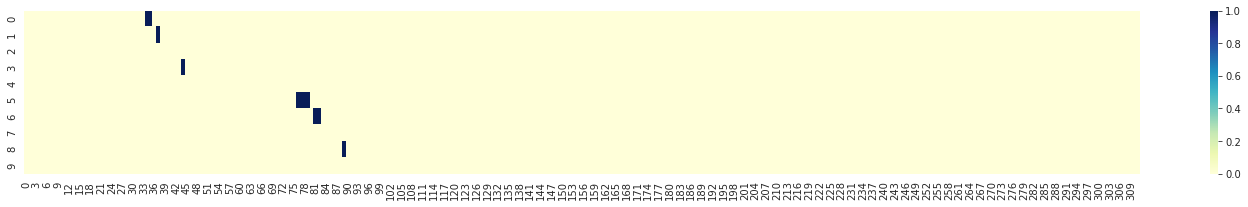

In [5]:
import numpy as np

from contract_agents import find_org_names, normalize_contract
from text_tools import tokenize_text, tokens_in_range

# TODO: import this
entities_types = ['type', 'name', 'alt_name', 'alias', 'type_ext']


def preprocess_contract(txt):
  trimmed = txt[0:2000]
  normalized_contract = normalize_contract(trimmed)
  return normalized_contract


def validate_find_patterns_in_contract_results(d):
  assert len(d) == 2


#   TODO:

def find_patterns_in_contract(normalized_contract: str):
  tokens = tokenize_text(normalized_contract)

  agents_infos = find_org_names(normalized_contract)
  validate_find_patterns_in_contract_results(agents_infos)

  cols = len(tokens)
  return make_matrix( (normalized_contract, agents_infos), cols )
#   rows_per_org = len(entities_types)

#   rows = 2 * rows_per_org   

#   matrix = np.zeros((rows, cols))

#   for agent_n in range(len(agents_infos)):
#     org = agents_infos[agent_n]

#     for i in range(rows_per_org):
#       entity_type = entities_types[i]
#       row =  agent_n * rows_per_org + i

#       span = org[entity_type][1]

#       if span[0] > 0:
#         text_slice = tokens_in_range(span, tokens, normalized_contract)
#         matrix[row][text_slice] = 1.0

#       row += 1
  
  
 
#   print(agents_infos[0])
#   print(agents_infos[1])
  
 
#   return matrix.T


def make_matrix(contract_info:tuple, matrix_len):
  tokens = tokenize_text(contract_info[0])
  agents_infos = contract_info[1]
   
  rows_per_org = len(entities_types)
  rows = 2 * rows_per_org   

  matrix = np.zeros((rows, matrix_len))

  for agent_n in range(2):
    org = agents_infos[agent_n]

    for i in range(rows_per_org):
      entity_type = entities_types[i]
      row =  agent_n * rows_per_org + i

      span = org[entity_type][1]

      if span[0] > 0:
        text_slice = tokens_in_range(span, tokens, contract_info[0])
        matrix[row][text_slice] = 1.0

      row += 1
  
  
 
#   print(agents_infos[0])
#   print(agents_infos[1])
  
 
  return matrix.T

  
  
def double_label_matrix_by_inversion(matrix):
  rows = matrix.shape[0]
  cols = matrix.shape[1]
  
  matrix_double = np.zeros((rows*2, cols))
  matrix_double[0:rows,0:cols] = matrix
  matrix_double[rows:2*rows,0:cols] = 1-matrix
  return matrix_double
    
  
  
### TESTS 🔞============✂️============⚙️========================================

import matplotlib.pyplot as plt
import seaborn as sns


  
  
  
  
t = preprocess_contract( list(contracts.values())[1] )
tokens = tokenize_text(t)
matrix = find_patterns_in_contract(t)


print(matrix[0])

color_matrix(matrix, tokens)
plot_matrix(matrix)

# Keras model

In [6]:
import os
import numpy as np

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D, Lambda, Add, BatchNormalization
from keras.layers import Dropout, concatenate
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report

from IPython.display import SVG

Using TensorFlow backend.


## Make dataset

### Augmentaion metoden

In [0]:
import random
import re
from typing import AnyStr, Match, Dict, List

def make_rnanom_name(lenn) -> str:
  return ''.join(random.choices('АБВГДЕЖЗИКЛМН', k=1) + random.choices('абвгдежопа ', k=lenn))


def augment_contract(txt: str, org_infos: List[Dict]):
  txt_a = txt
  for org in org_infos:
    for e in ['name', 'alias', 'alt_name']:
      substr = org[e][0]
      if substr and substr!='':
        r = re.compile(substr)
        txt_a = re.sub(r, make_rnanom_name(10), txt_a)

  return txt_a, find_org_names(txt_a)

In [8]:
data = list(contracts.keys())

PARSED=[]
for fn in data:  
  con = contracts[fn]
  normalized_contract = preprocess_contract( con )
  
  try:
    agents_infos = find_org_names(normalized_contract)
    validate_find_patterns_in_contract_results(agents_infos)
#     PARSED.append( (normalized_contract, agents_infos) )


    for c in range(5):
      PARSED.append( augment_contract (normalized_contract, agents_infos) )
     
  except:
    print(f'ERROR: {fn}')

for e in PARSED:
  print(e[1])
  
  
##-----------------
from text_tools import untokenize

_TEXTS=[]
_TEXTS_tmp=[]
_LENS_tmp=[]

_LABELS=[]
_LENS=[]
data = list(contracts.keys())

 
for t, _ in PARSED:  
  tokens = tokenize_text(t)  
  _TEXTS_tmp.append(tokens)
  _LENS_tmp.append(len(tokens))

#PADDING
 
_longest_len = _LENS_tmp[np.argmax(_LENS_tmp)  ]  +10
print('_longest_len',_longest_len)
for i in range(len(_TEXTS_tmp)):
  _TEXTS_tmp[i] = _TEXTS_tmp[i] + ['PAD']* (_longest_len - len(_TEXTS_tmp[i]))
  
 
for i in range( len(PARSED)):  #:[39:45]:
 

  tokens = _TEXTS_tmp[i]
  t = PARSED[i][0]


  ###-----
  matrix = make_matrix(PARSED[i], _longest_len)
  ###----
 
  assert len(matrix) == _longest_len

  _TEXTS.append(tokens)
  _LENS.append(len(tokens))
  _LABELS.append(matrix)



#   print('matrix.shape',matrix.shape)

  
   

print(len(_TEXTS))

ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/7. Соглашение БГ Газпромнефть-Региональные продажи.doc
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/Договор_ООО Зодчий_25 млн.$.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/ДКП Половинной НБ и АЗС.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/Проект договора Пур адм.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/Договор аренды.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/Договор 2.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/Договор выполнения работ_Петров.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/1.1. Договор пожертвования.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/Проект договора Пур адм - благотв.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/МНПЗ 2 Договор купли-продажи недвижимого имущества.docx
ERROR: /content/gdrive/My Drive/GazpromOil/Contracts/ЕЮ2 Договор пожертвования (одаряемый).docx
ERROR: /content/gdrive/My 

In [0]:
# from text_tools import untokenize

# _TEXTS=[]
# _TEXTS_tmp=[]
# _LENS_tmp=[]

# _LABELS=[]
# _LENS=[]
# data = list(contracts.keys())

 
# for fn in data:  
#   con = contracts[fn]
#   t = preprocess_contract( con )
#   tokens = tokenize_text(t)  
#   _TEXTS_tmp.append(tokens)
#   _LENS_tmp.append(len(tokens))

# #PADDING
 
# _longest_len = _LENS_tmp[np.argmax(_LENS_tmp)  ] 
# print('_longest_len',_longest_len)
# for i in range(len(_TEXTS_tmp)):
#   _TEXTS_tmp[i] = _TEXTS_tmp[i] + ['PAD']* (_longest_len - len(_TEXTS_tmp[i]))
  
 
   
# for i in range( len(data)):  #:[39:45]:
#   try:
#     print(i, data[i])
    
# #     con = contracts[fn]

#     tokens = _TEXTS_tmp[i]
#     t = untokenize(tokens)


#     ###-----
#     _matrix = find_patterns_in_contract(t)
#     ###----
  
#     matrix = np.zeros( (_longest_len, _matrix.shape[1]) )
#     matrix[:_matrix.shape[0],:_matrix.shape[1]] = _matrix
#     print(matrix.shape)
#     assert len(matrix) == _longest_len

#     _TEXTS.append(tokens)
#     _LENS.append(len(tokens))
#     _LABELS.append(matrix)



#     print(matrix.shape)

#   except:
#     print('ERROR:')
   

# print(len(_TEXTS))

### Plot sample label  matrices

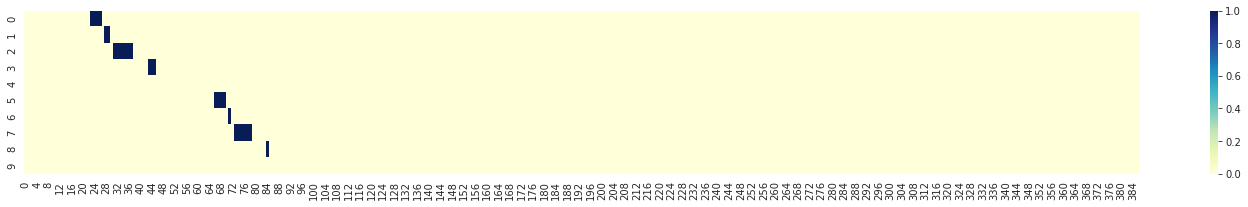

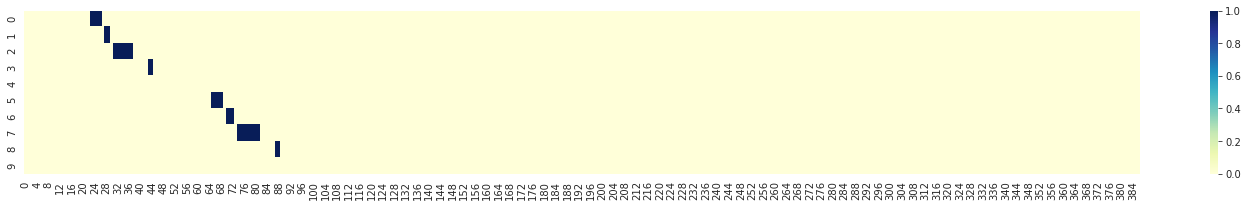

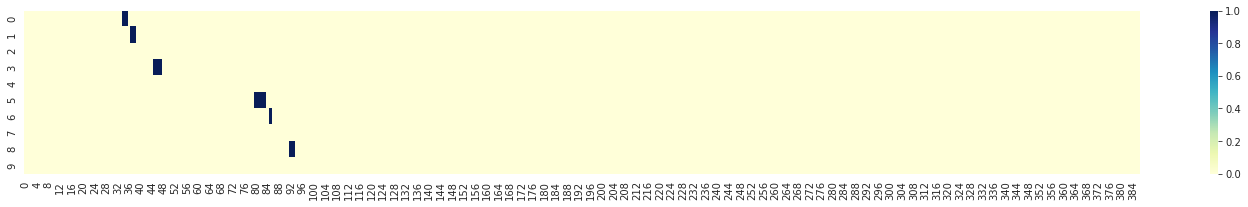

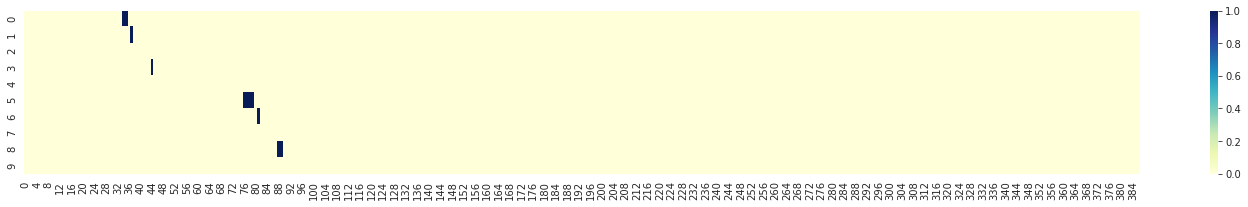

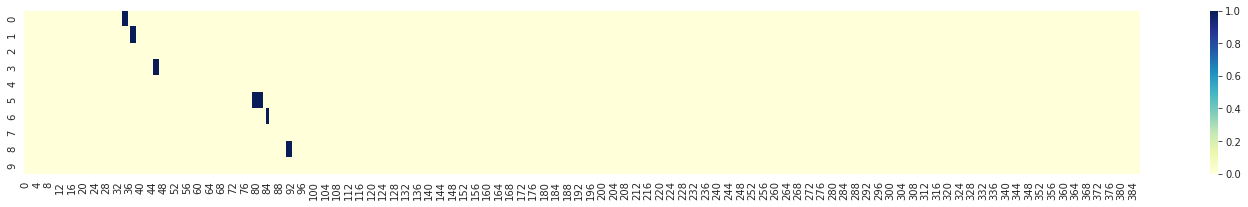

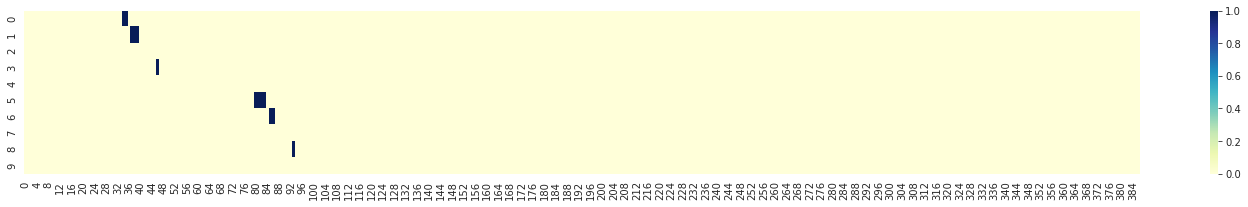

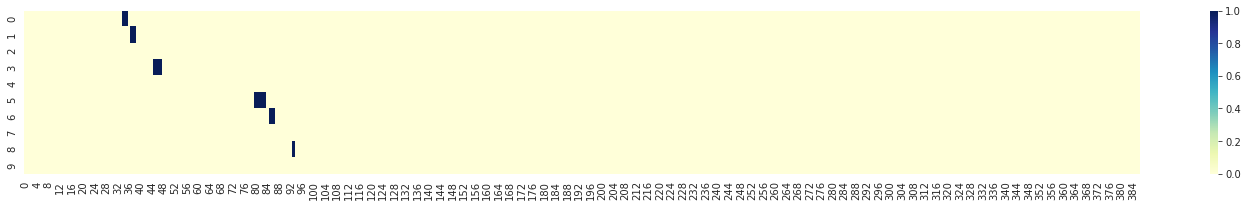

In [10]:
for m in _LABELS[3:10]:
  plot_matrix(m) 

# MODEL

## ELMo module support  

In [0]:

import tensorflow as tf

module_url = 'https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz'


In [0]:
EMB_DIM=1024

def get_embedings(inputs):
  r = elmo(
    inputs={
      "tokens": inputs[0],
      "sequence_len": tf.squeeze(inputs[1])
    },
    signature="tokens",
    as_dict=True)["elmo"]

  return r


# ------
def elmo_output_shape(input_shapes):
  shape1 = list(input_shapes)
  shape1[-1] = EMB_DIM
  return tuple(shape1)




## The Model

In [0]:
from keras import backend as K
from keras.objectives import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers import Concatenate

# adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


def custom_loss(y_true, y_pred):
  return K.mean( K.square(y_pred - y_true) )
  
  
  
def get_conv_pool(x_input, sufix, feature_maps, n=3, activation='relu'):
  branch = Conv1D( filters = feature_maps, kernel_size=(n), padding='same', activation=activation, name='Conv_'+sufix+'_'+str(n))(x_input)
  return branch



def custom_categorical_crossentropy(x, y):
    x = K.flatten(x)
    y = K.flatten(y)
    return categorical_crossentropy(x, y)

  
  
  
def build_model(features): 
  # inputs:--------------------------------------------------------------------
  text_input = Input(shape=[None,], dtype='string', name="text_input")
  text_lengths = Input(batch_shape=[None, 1], dtype='int32', name='text_lengths')
  # ------------------------------------------------------------------- /inputs
   
  embedding = Lambda(get_embedings, (EMB_DIM, ), name="deeppavlov".upper())( [text_input, text_lengths]  )

  conv_0 = get_conv_pool(embedding, 'c0', n=4, feature_maps=2, activation='sigmoid' )  
  conv_00 = get_conv_pool(embedding, 'c00', n=10, feature_maps=2, activation='sigmoid' )  
  conv_1 = get_conv_pool(embedding, 'c1', n=3, feature_maps=features*2, activation='sigmoid' )  
  conv_2 = get_conv_pool(embedding, 'c2', n=5, feature_maps=features*2, activation='sigmoid')
  
#   conv_sum = Add()([conv_1, conv_2]) 
  
  conv_sum = Concatenate()([conv_00, conv_0, conv_1, conv_2]) 
  
  conv_3 = get_conv_pool(conv_sum, 'c3', n=3, feature_maps=features, activation='sigmoid')
  conv_4 = get_conv_pool(conv_3, 'c4', n=3, feature_maps=features, activation='sigmoid')
  
  model = Model(inputs=[text_input, text_lengths], outputs=conv_4)

  adam = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss=custom_categorical_crossentropy, optimizer=adam)
  model.summary()
  
  return model






W0515 03:41:49.474153 140259739957120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
text_lengths (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
DEEPPAVLOV (Lambda)             (None, 1024)         0           text_input[0][0]                 
                                                                 text_lengths[0][0]               
__________________________________________________________________________________________________
Conv_c00_10 (Conv1D)            (None, 2)            20482       DEEPPAVLOV[0][0]                 
__________

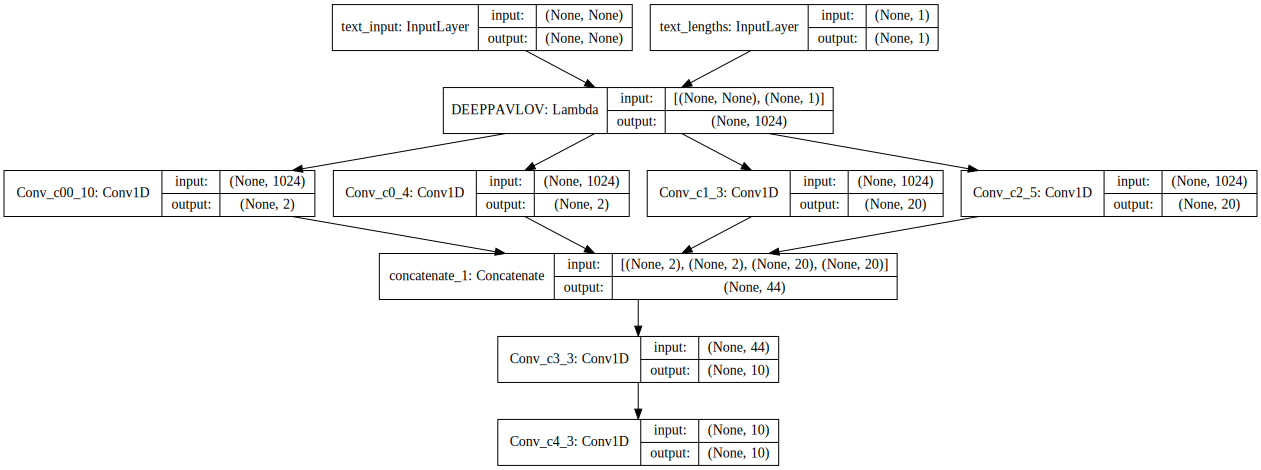

In [14]:
np_LABELS = np.array(_LABELS)

graph = tf.Graph()

with graph.as_default():  
  elmo = hub.Module(module_url, trainable=False)
  model = build_model( np_LABELS.shape[-1] )
  
  
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## Fit

W0515 03:41:52.562688 140259739957120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/4
145/145 [==============================] - 13s 89ms/step - loss: 5069.6651
Epoch 2/4
145/145 [==============================] - 8s 57ms/step - loss: 4802.4966
Epoch 3/4
145/145 [==============================] - 9s 60ms/step - loss: 4423.2186
Epoch 4/4
145/145 [==============================] - 8s 56ms/step - loss: 3922.1533


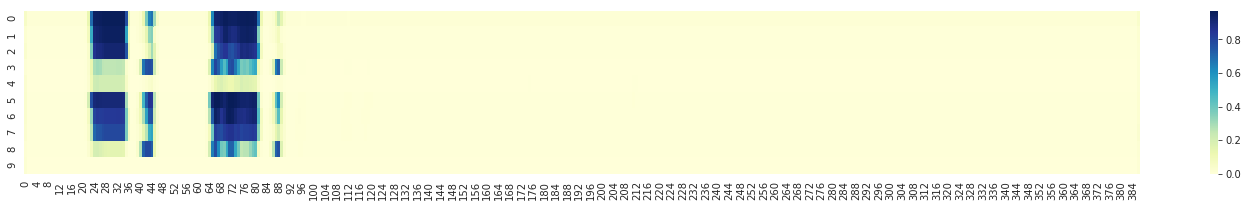

Epoch 1/4
145/145 [==============================] - 8s 56ms/step - loss: 3646.2878
Epoch 2/4
145/145 [==============================] - 8s 56ms/step - loss: 3475.5646
Epoch 3/4
145/145 [==============================] - 8s 56ms/step - loss: 3291.5468
Epoch 4/4
145/145 [==============================] - 8s 55ms/step - loss: 3100.0590


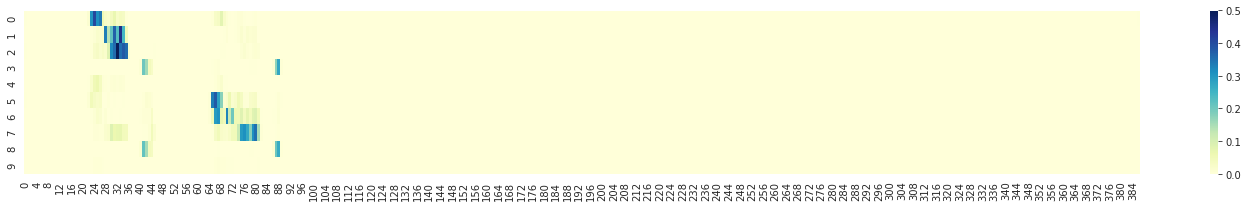

Epoch 1/4
145/145 [==============================] - 8s 55ms/step - loss: 3005.2959
Epoch 2/4
145/145 [==============================] - 8s 56ms/step - loss: 2929.4766
Epoch 3/4
145/145 [==============================] - 8s 57ms/step - loss: 2873.1073
Epoch 4/4
145/145 [==============================] - 8s 55ms/step - loss: 2898.3136


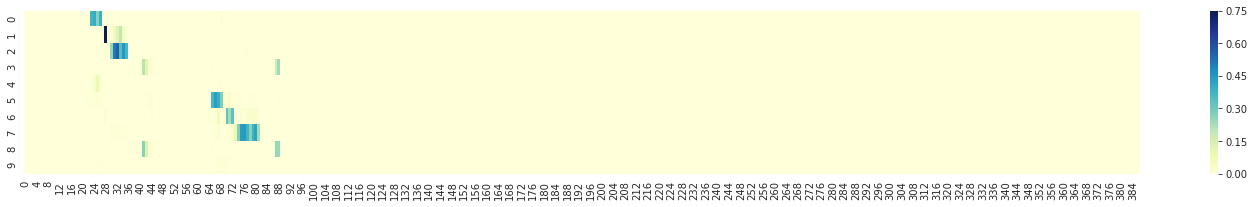

Epoch 1/4
145/145 [==============================] - 8s 56ms/step - loss: 2845.9142
Epoch 2/4
145/145 [==============================] - 8s 56ms/step - loss: 2821.0594
Epoch 3/4
145/145 [==============================] - 8s 56ms/step - loss: 2867.5602
Epoch 4/4
145/145 [==============================] - 8s 56ms/step - loss: 2817.6817


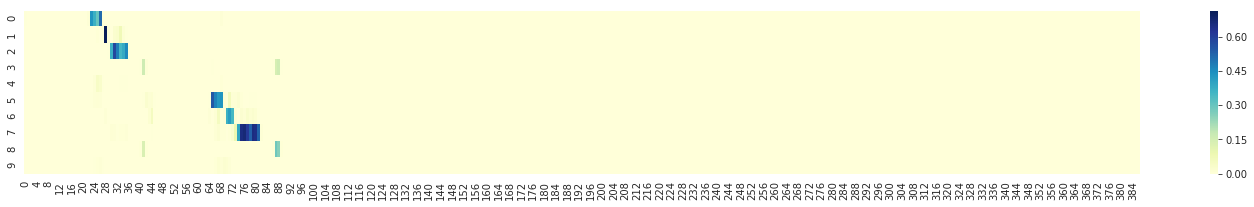

Epoch 1/4
145/145 [==============================] - 8s 58ms/step - loss: 2792.7828
Epoch 2/4
145/145 [==============================] - 8s 57ms/step - loss: 2780.6793
Epoch 3/4
145/145 [==============================] - 8s 55ms/step - loss: 2788.6159
Epoch 4/4
145/145 [==============================] - 8s 57ms/step - loss: 2779.0979


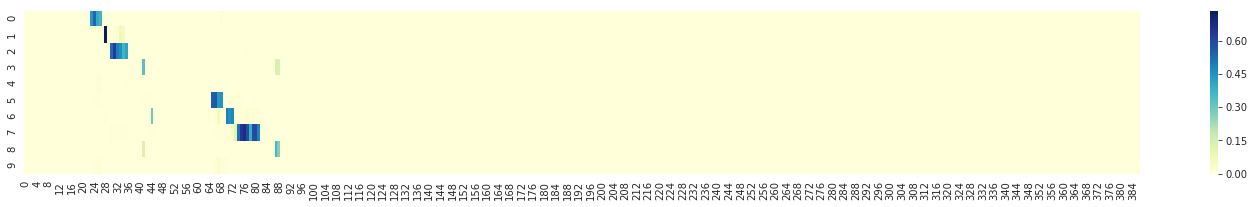

Epoch 1/4
145/145 [==============================] - 8s 56ms/step - loss: 2763.2145
Epoch 2/4
145/145 [==============================] - 8s 56ms/step - loss: 2768.6926
Epoch 3/4
145/145 [==============================] - 8s 56ms/step - loss: 2752.4438
Epoch 4/4
145/145 [==============================] - 8s 56ms/step - loss: 2778.2465


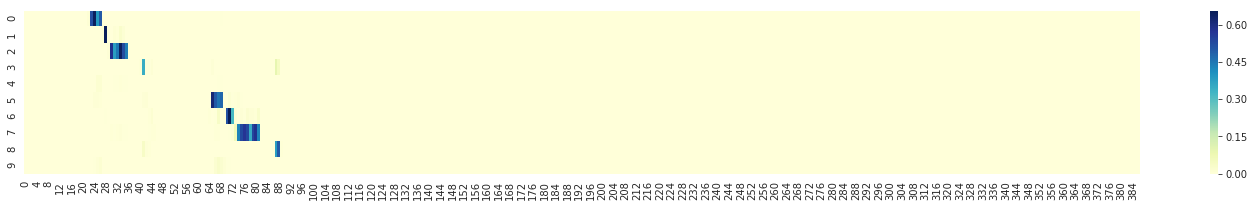

Epoch 1/4
145/145 [==============================] - 8s 55ms/step - loss: 2721.8954
Epoch 2/4
145/145 [==============================] - 8s 56ms/step - loss: 2700.1870
Epoch 3/4
145/145 [==============================] - 8s 56ms/step - loss: 2710.2383
Epoch 4/4
145/145 [==============================] - 8s 55ms/step - loss: 2724.4952


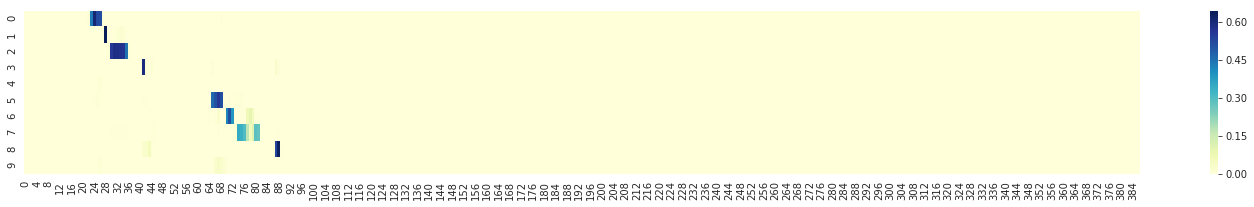

Epoch 1/4
145/145 [==============================] - 8s 57ms/step - loss: 2734.4368
Epoch 2/4
145/145 [==============================] - 8s 56ms/step - loss: 2734.0384
Epoch 3/4
145/145 [==============================] - 8s 55ms/step - loss: 2722.2159
Epoch 4/4
145/145 [==============================] - 8s 56ms/step - loss: 2722.5387


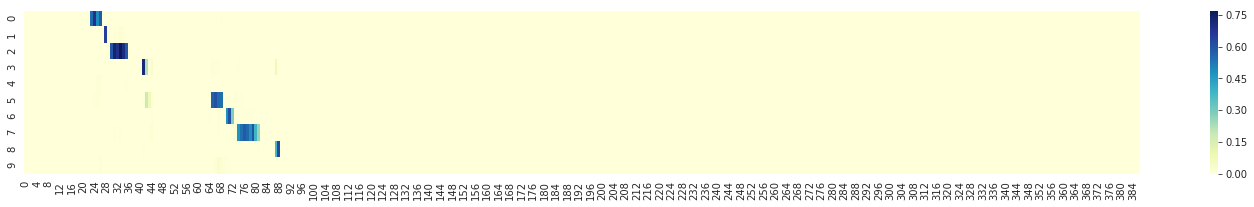

Epoch 1/4
145/145 [==============================] - 8s 55ms/step - loss: 2756.0387
Epoch 2/4
145/145 [==============================] - 8s 55ms/step - loss: 2725.9523
Epoch 3/4
145/145 [==============================] - 8s 56ms/step - loss: 2764.1715
Epoch 4/4
145/145 [==============================] - 8s 56ms/step - loss: 2684.7081


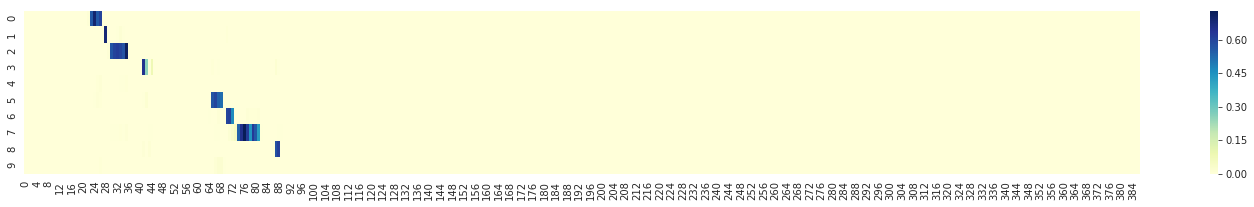

Epoch 1/4
145/145 [==============================] - 8s 55ms/step - loss: 2693.3846
Epoch 2/4
145/145 [==============================] - 8s 56ms/step - loss: 2695.2705
Epoch 3/4
145/145 [==============================] - 8s 57ms/step - loss: 2726.6531
Epoch 4/4
145/145 [==============================] - 8s 55ms/step - loss: 2724.2137


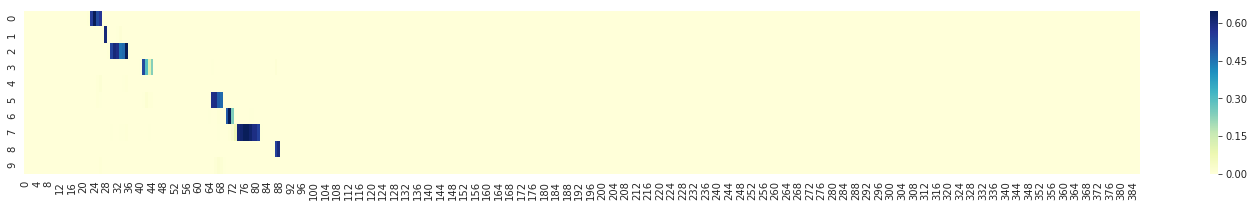

In [15]:



with graph.as_default():  
 
  with tf.Session() as sess:
   
    K.set_session(sess) 
    
    for i in range(10):
      model.fit([_TEXTS[10:], _LENS[10:] ], np_LABELS[10:] , epochs=4)
      pred = model.predict([_TEXTS[0:2], _LENS[0:2] ])

      plot_matrix(pred[0])
      color_matrix(pred[0], _TEXTS[0])

    



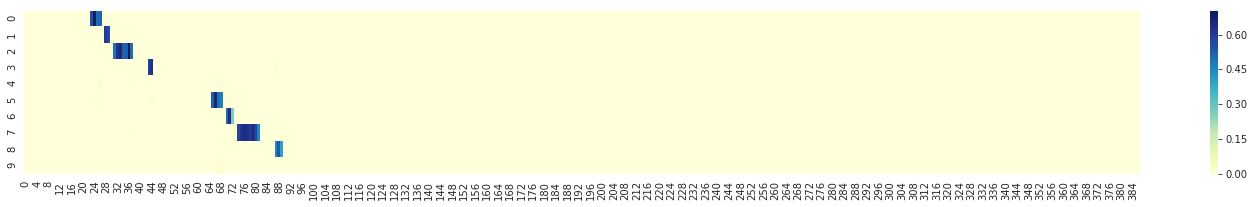

In [16]:
plot_matrix(pred[1])
color_matrix(pred[1], _TEXTS[1])